# Configuração do Ambiente

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 16 17:18:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
names=["id", "runtime", "Setting1", 'Setting2', 'Setting3', 'Tag1', 'Tag2', 'Tag3', 'Tag4', 
       'Tag5','Tag6', 'Tag7', 'Tag8', 'Tag9', 'Tag10', 'Tag11', 'Tag12', 'Tag13', 
       'Tag14', 'Tag15', 'Tag16', 'Tag17', 'Tag18', 'Tag19', 'Tag20', 'Tag21']

# Classificação binária
Preveja se um ativo falhará dentro de um determinado período (por exemplo, ciclos)

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

## Lendo os Dados

In [ ]:
#Dados de Treino
df = pd.read_csv('PM_train.txt', header=None, delimiter=r"\s+", names=names)
df = df.sort_values(['id','runtime'])

#Dados de Teste
df_test = pd.read_csv('PM_test.txt', header=None, delimiter=r"\s+", names=names)

##Fazendo uma coluna para os dados RUL
De acordo com o documento de descrição de dados, o conjunto de dados contém várias unidades, cada unidade começa em um determinado ponto de degradação e os dados de medição terminam bem antes da unidade ser desativada por quebra.

Portanto, suponha que, para o último tempo de medição que está disponível para uma unidade, as unidades RUL = 0 (parou de medir pouco antes da quebra da máquina)

In [ ]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(df.groupby('id')['runtime'].max()).reset_index()
rul.columns = ['id', 'max']
df = df.merge(rul, on=['id'], how='left')
df['RUL'] = df['max'] - df['runtime']
df.drop('max', axis=1, inplace=True)

# gerar colunas de rótulo para dados de treinamento
# só faremos uso de "label1" para classificação binária,
w1 = 25
w0 = 15
df['label1'] = np.where(df['RUL'] <= w1, 1, 0 )
df['label2'] = df['label1']
df.loc[df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization
df['cycle_norm'] = df['runtime']
cols_normalize = df.columns.difference(['id','runtime','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df.index)
join_df = df[df.columns.difference(cols_normalize)].join(norm_train_df)
df = join_df.reindex(columns = df.columns)

In [ ]:
# Separando os dados de PM_training para Treino e Teste.
units = df['id'].unique()
n_units = len(df['id'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

test_df = df.loc[df['id'].apply( lambda x: x in units_test )].copy()
train_df = df.loc[df['id'].apply( lambda x: x in units_train )].copy()

In [ ]:
######
# TEST
######
# MinMax normalization (from 0 to 1)
# Rotulagem de dados - gerar coluna RUL (vida útil remanescente ou tempo de falha)
rul = pd.DataFrame(df_test.groupby('id')['runtime'].max()).reset_index()
rul.columns = ['id', 'max']
df_test = df_test.merge(rul, on=['id'], how='left')
df_test['RUL'] = df_test['max'] - df_test['runtime']
df_test.drop('max', axis=1, inplace=True)
w1 = 30
w0 = 15

df_test['label1'] = np.where(df_test['RUL'] <= w1, 1, 0 )
df_test['label2'] = df_test['label1']
df_test.loc[df_test['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
df_test['cycle_norm'] = df_test['runtime']
cols_normalize = df_test.columns.difference(['id','runtime','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_df_test = pd.DataFrame(min_max_scaler.fit_transform(df_test[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_test.index)
join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_df_test)
df_test = join_df.reindex(columns = df_test.columns)

In [ ]:
train_df.head()

,id,runtime,Setting1,Setting2,Setting3,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,Tag9,Tag10,Tag11,Tag12,Tag13,Tag14,Tag15,Tag16,Tag17,Tag18,Tag19,Tag20,Tag21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [ ]:
test_df.head()

,id,runtime,Setting1,Setting2,Setting3,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,Tag9,Tag10,Tag11,Tag12,Tag13,Tag14,Tag15,Tag16,Tag17,Tag18,Tag19,Tag20,Tag21,RUL,label1,label2,cycle_norm
1116,6,1,0.390805,0.750000,0.0,0.0,0.457831,0.291258,0.507934,0.0,1.0,0.505636,0.333333,0.069685,0.0,0.422619,0.639659,0.352941,0.087316,0.399000,0.0,0.500000,0.0,0.0,0.620155,0.572218,187,0,0,0.00000
1117,6,2,0.620690,0.166667,0.0,0.0,0.259036,0.421626,0.318197,0.0,1.0,0.510467,0.287879,0.108678,0.0,0.476190,0.498934,0.279412,0.134534,0.420931,0.0,0.416667,0.0,0.0,0.581395,0.511323,186,0,0,0.00277
1118,6,3,0.321839,0.583333,0.0,0.0,0.409639,0.373665,0.398548,0.0,1.0,0.468599,0.348485,0.103294,0.0,0.380952,0.637527,0.338235,0.131851,0.316660,0.0,0.333333,0.0,0.0,0.503876,0.444767,185,0,0,0.00554
1119,6,4,0.534483,0.500000,0.0,0.0,0.228916,0.400262,0.320054,0.0,1.0,0.523349,0.303030,0.068384,0.0,0.315476,0.671642,0.382353,0.088348,0.293574,0.0,0.500000,0.0,0.0,0.534884,0.590030,184,0,0,0.00831
1120,6,5,0.666667,0.083333,0.0,0.0,0.424699,0.525180,0.462863,0.0,1.0,0.550725,0.378788,0.085794,0.0,0.380952,0.571429,0.441176,0.124677,0.513274,0.0,0.500000,0.0,0.0,0.565891,0.593482,183,0,0,0.01108


##Rede LSTM
Em seguida, construímos uma rede profunda. A primeira camada é uma camada LSTM com 100 unidades seguida por outra camada LSTM com 50 unidades. A exclusão também é aplicada após cada camada LSTM para controlar o sobreajuste. A camada final é uma camada de saída Densa com unidade única e ativação sigmóide, uma vez que este é um problema de classificação binária.

In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['Tag' + str(i) for i in range(1,22)]
sequence_cols = ['Setting1', 'Setting2', 'Setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_path = 'binary_model.h5'
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/100
61/61 - 26s - loss: 0.2389 - accuracy: 0.9049 - val_loss: 0.1450 - val_accuracy: 0.9361
Epoch 2/100
61/61 - 1s - loss: 0.0990 - accuracy: 0.9608 - val_loss: 0.0883 - val_accuracy: 0.9548
Epoch 3/100
61/61 - 1s - loss: 0.0791 - accuracy: 0.9673 - val_loss: 0.0702 - val_accuracy: 0.9688
Epoch 4/100
61/61 - 1s - loss: 0.0674 - accuracy: 0.9729 - val_loss: 0.0709 - val_accuracy: 0.9798
Epoch 5/100
61/61 - 1s - loss: 0.0667 - accuracy: 0.9718 - val_loss: 0.0914 - val_accuracy: 0.9595
Epoch 6/100
61/61 - 1s - loss: 0.0588 - accuracy: 0.9749 - val_loss: 0.0710 - val_accuracy: 0.9688
Epoch 7/100
61/61 - 1s - loss: 0.0678 - accuracy: 0.9722 - val_loss: 0.0523 - val_accuracy: 0.9907
Epoch 8/100
61/61 - 1s - loss: 0.0580 - accuracy: 0.9739 - val_loss: 0.0721 - val_accuracy: 0.9704
Epoch 9/100
61/61 - 1s - loss: 0.0504 - accuracy: 0.9782 - val_loss: 0.0929 - val_accuracy: 0.9579
Epoch 10/100
61/61 - 1s - loss: 0.0522 - accuracy: 0.9772 - val_loss: 0.0664 - val_accuracy: 0.9735
Epoch 11

##Model Evaluation on Test set

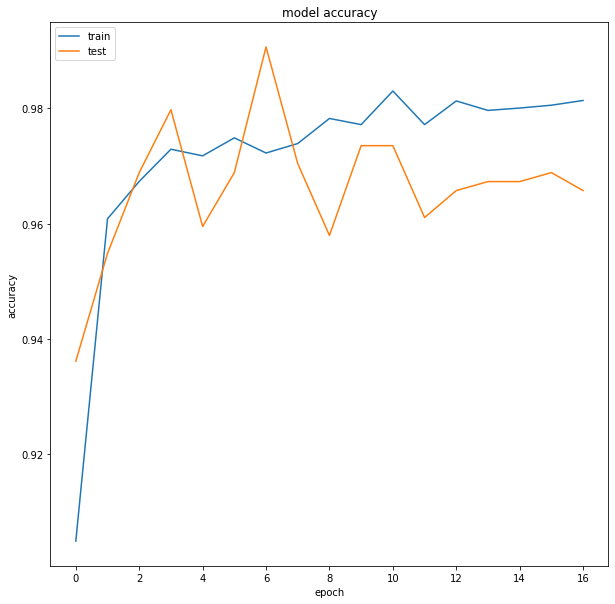

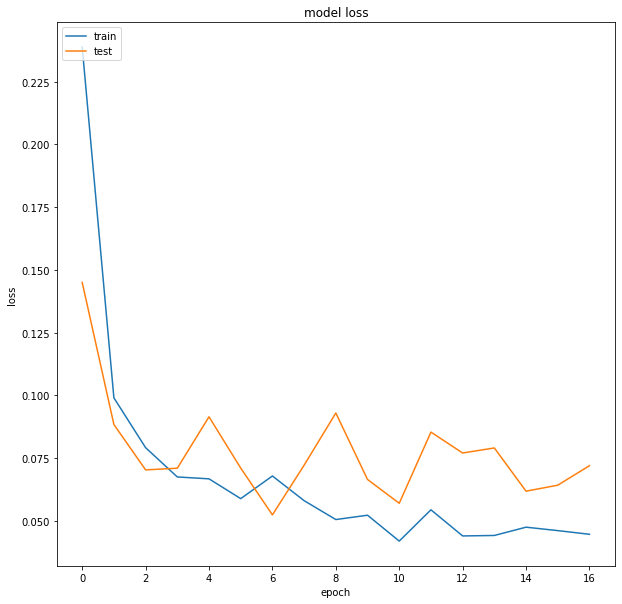

65/65 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.9828
Accurracy: 0.9828406572341919


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


65/65 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[10548   193]
 [   27  2053]]
precision =  0.9140694568121104 
 recall =  0.9870192307692308


In [ ]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Fazendo Previsões nos dados PM_test

In [ ]:
#Escolhemos a última sequência para cada id nos dados de teste

seq_array_test_last = [df_test[df_test['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in df_test['id'].unique() if len(df_test[df_test['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
y_mask = [len(df_test[df_test['id']==id]) >= sequence_length for id in df_test['id'].unique()]

label_array_test_last = df_test.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Fazendo predições e salvadno em csv
y_pred_test = estimator.predict_classes(seq_array_test_last)
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Regressão


Quantos ciclos a mais um mecanismo em serviço vai durar antes de falhar?

In [45]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import random
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

In [46]:
#Dados de Treino
df = pd.read_csv('PM_train.txt', header=None, delimiter=r"\s+", names=names)
df = df.sort_values(['id','runtime'])

#Dados de Teste
df_test = pd.read_csv('PM_test.txt', header=None, delimiter=r"\s+", names=names)

In [35]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(df.groupby('id')['runtime'].max()).reset_index()
rul.columns = ['id', 'max']
df = df.merge(rul, on=['id'], how='left')
df['RUL'] = df['max'] - df['runtime']
df.drop('max', axis=1, inplace=True)

# gerar colunas de rótulo para dados de treinamento
# só faremos uso de "label1" para classificação binária,
w1 = 30
w0 = 15
df['label1'] = np.where(df['RUL'] <= w1, 1, 0 )
df['label2'] = df['label1']
df.loc[df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization
df['cycle_norm'] = df['runtime']
cols_normalize = df.columns.difference(['id','runtime','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df.index)
join_df = df[df.columns.difference(cols_normalize)].join(norm_train_df)
df = join_df.reindex(columns = df.columns)

In [36]:
# Separando os dados de PM_training para Treino e Teste.
units = df['id'].unique()
n_units = len(df['id'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

test_df = df.loc[df['id'].apply( lambda x: x in units_test )].copy()
train_df = df.loc[df['id'].apply( lambda x: x in units_train )].copy()

In [37]:
######
# TEST
######
# MinMax normalization (from 0 to 1)
# Rotulagem de dados - gerar coluna RUL (vida útil remanescente ou tempo de falha)
rul = pd.DataFrame(df_test.groupby('id')['runtime'].max()).reset_index()
rul.columns = ['id', 'max']
df_test = df_test.merge(rul, on=['id'], how='left')
df_test['RUL'] = df_test['max'] - df_test['runtime']
df_test.drop('max', axis=1, inplace=True)
w1 = 30
w0 = 15

df_test['label1'] = np.where(df_test['RUL'] <= w1, 1, 0 )
df_test['label2'] = df_test['label1']
df_test.loc[df_test['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
df_test['cycle_norm'] = df_test['runtime']
cols_normalize = df_test.columns.difference(['id','runtime','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_df_test = pd.DataFrame(min_max_scaler.fit_transform(df_test[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_test.index)
join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_df_test)
df_test = join_df.reindex(columns = df_test.columns)

In [38]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Apenas as sequências que atendem ao comprimento da janela são consideradas, 
     nenhum preenchimento é usado. Isso significa para o teste precisamos eliminar 
     aqueles que estão abaixo do comprimento da janela. Uma alternativa seria preencher 
     as sequências para que podemos usar os mais curtos """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['Tag' + str(i) for i in range(1,22)]
sequence_cols = ['Setting1', 'Setting2', 'Setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

142
(12151, 50, 25)


(12151, 1)

##LSTM

In [39]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
__________________________________________________

In [40]:
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
print(history.history.keys())

Epoch 1/100
58/58 - 6s - loss: 8585.4463 - mae: 74.2085 - r2_keras: -1.7223e+00 - val_loss: 4423.9014 - val_mae: 53.7625 - val_r2_keras: -4.9833e+00
Epoch 2/100
58/58 - 1s - loss: 7993.5200 - mae: 70.6704 - r2_keras: -1.5403e+00 - val_loss: 4120.7583 - val_mae: 51.4852 - val_r2_keras: -7.7537e+00
Epoch 3/100
58/58 - 1s - loss: 7587.7427 - mae: 68.3118 - r2_keras: -1.4011e+00 - val_loss: 3840.0422 - val_mae: 49.3883 - val_r2_keras: -1.1307e+01
Epoch 4/100
58/58 - 1s - loss: 7209.1177 - mae: 66.0876 - r2_keras: -1.2832e+00 - val_loss: 3576.6292 - val_mae: 47.4334 - val_r2_keras: -1.5680e+01
Epoch 5/100
58/58 - 1s - loss: 6850.5352 - mae: 63.9913 - r2_keras: -1.1666e+00 - val_loss: 3330.0664 - val_mae: 45.6173 - val_r2_keras: -2.0880e+01
Epoch 6/100
58/58 - 1s - loss: 6504.7798 - mae: 62.0189 - r2_keras: -1.0575e+00 - val_loss: 3100.1758 - val_mae: 43.9392 - val_r2_keras: -2.6917e+01
Epoch 7/100
58/58 - 1s - loss: 6170.4390 - mae: 60.0963 - r2_keras: -9.4929e-01 - val_loss: 2888.1755 - va

## Model Evaluation on Test set

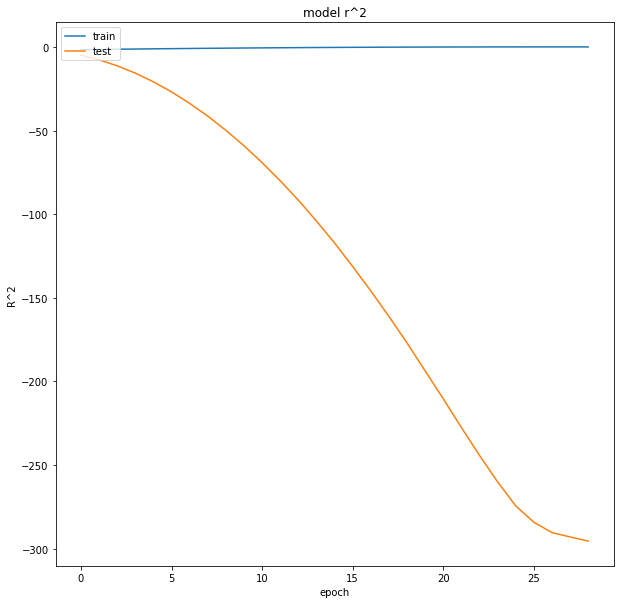

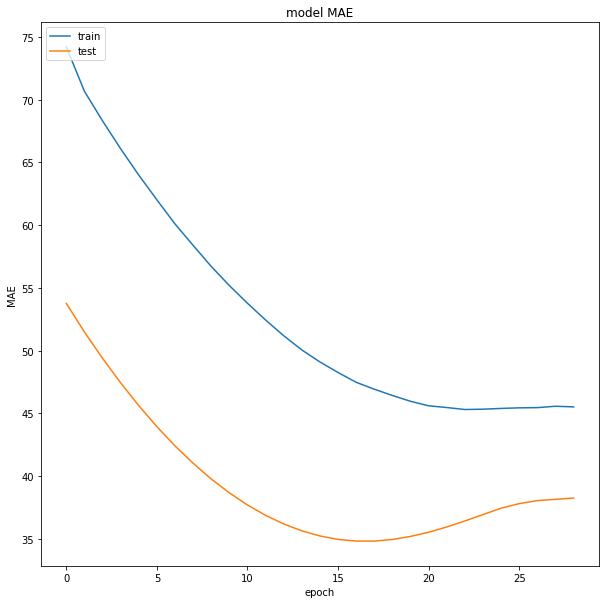

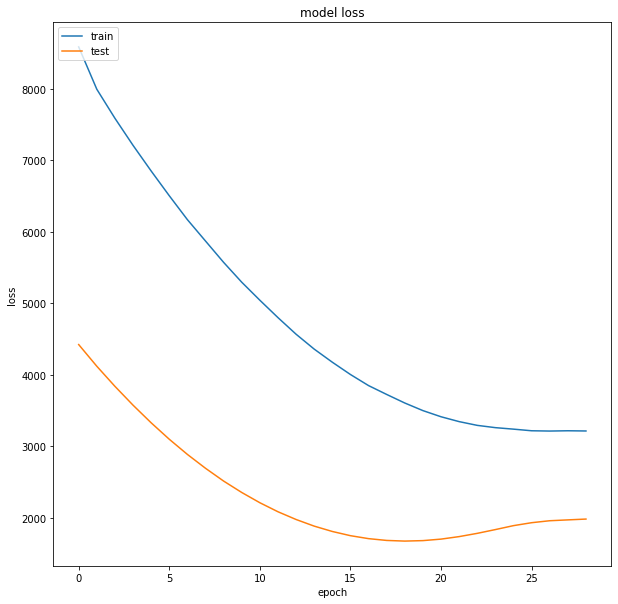

61/61 [==============================] - 0s 6ms/step - loss: 3123.0425 - mae: 44.9777 - r2_keras: -0.2413

MAE: 44.977657318115234

R^2: -0.24125537276268005
61/61 [==============================] - 1s 5ms/step


In [41]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

## Evaluate on Validation set

In [42]:
# Nós escolhemos a última sequência para cada id nos dados de teste
seq_array_test_last = [df_test[df_test['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in df_test['id'].unique() if len(df_test[df_test['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(df_test[df_test['id']==id]) >= sequence_length for id in df_test['id'].unique()]
label_array_test_last = df_test.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)